# Status of COVID-19 Cases in Ontario

URL: https://data.ontario.ca/dataset/status-of-covid-19-cases-in-ontario

Ontario data tools: https://www.publichealthontario.ca/en/data-and-analysis/infectious-disease/covid-19-data-surveillance/covid-19-data-tool?tab=summary

## Data Preparation

In [1]:
%matplotlib inline

import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

# make the plots a bit prettier, with shaded grids
plt.style.use('ggplot')

# This is necessary to show lots of columns in pandas 0.12. 
# Not necessary in pandas 0.13.
pd.set_option('display.width', 5000) 
pd.set_option('display.max_columns', 60)

daily_change_url = 'https://data.ontario.ca/dataset/f4f86e54-872d-43f8-8a86-3892fd3cb5e6/resource/8a88fe6d-d8fb-41a3-9d04-f0550a44999f/download/daily_change_in_cases_by_phu.csv'
#daily_change_url = 'data/covid19_ontario_daily.csv'
df = pd.read_csv(daily_change_url)

# Check last data point
print("Last data point on:", df.Date.max())

Last data point on: 2022-03-08


In [2]:
#df.columns

In [3]:
# Change date column to proper type and create another dataframe of dates to extract weekends
df.Date = pd.to_datetime(df.Date)
dfd = pd.DataFrame(df.Date)
#dfd['day_of_week'] = dfd.Date.dt.day_of_week

# for Pandas version 1.1.5
dfd['day_of_week'] = dfd.Date.dt.dayofweek

# Monday = 0, weekend = 4,5,6
#dfd['is_wkend_holiday']=(dfd.day_of_week >= 4) * 1
dfd['is_wekend_holiday'] = 0   # ignore weekends

In [4]:
# extract holidays (2020, 2021)
import datetime
holidays = ['2020-01-01', '2020-02-17', '2020-04-10', '2020-05-18', '2020-07-01', '2020-09-07', '2020-10-12', '2020-12-25']
holidays.extend(['2021-01-01', '2021-02-15', '2021-04-02', '2021-05-24', '2021-07-01', '2021-09-06', '2021-10-11', '2021-12-25', '2021-12-26', '2021-12-27'])
holidays.extend(['2022-01-03', '2022-02-21', '2022-04-15', '2022-05-23', '2022-07-01', '2022-09-05', '2022-10-10', '2022-12-25', '2022-12-26'])

# add halloweens and Valentines
holidays.extend(['2020-02-14', '2020-10-31', '2021-02-14', '2021-10-31'])
holidays = [datetime.datetime.strptime(date, '%Y-%m-%d').date() for date in holidays]
for d in dfd.Date:
    if d in holidays:
        dfd.loc[dfd['Date']==d, "is_wkend_holiday"] = 1
        #print(dfd[dfd['Date']==d].is_wkend_holiday)
        
#dfd['is_wkend_holiday'] = dfd.is_wekend_holiday.fillna(0)
dfd.is_wkend_holiday = dfd.is_wkend_holiday.replace(np.nan, 0)

In [5]:
# check a holiday
dfd.loc[dfd.Date==datetime.datetime(2021,2,15)]
#dfd.loc[dfd.Date == datetime.datetime(2021,2,13)]


,Date,day_of_week,is_wekend_holiday,is_wkend_holiday
328,2021-02-15,0,0,1.0


In [6]:
# add columns for holiday+1 and holiday+5 days
holiday_add1 = (dfd.loc[dfd.is_wkend_holiday==1, "Date"] + datetime.timedelta(days=1)).tolist()
holiday_add5 = (dfd.loc[dfd.is_wkend_holiday==1, "Date"] + datetime.timedelta(days=5)).tolist()

dfd['holiday_add1'] = 0
dfd['holiday_add5'] = 0

for d in dfd.Date:
    if d in holiday_add1:
        dfd.loc[dfd['Date']==d, "holiday_add1"] = 1
    if d in holiday_add5:
        dfd.loc[dfd['Date']==d, "holiday_add5"] = 1

dfd.set_index('Date', inplace=True)

In [7]:
# Set df dataframe index to the date column
df.set_index('Date', inplace=True)

## Compute Moving Average

A moving average, aka a rolling or running average, is used to analyze the time-series data by calculating averages of different subsets of the complete dataset. It is also called a moving mean (MM) or rolling mean.

In [8]:
## Calculate 7-day SMA for the total positive COVID cases
df['Total_SMA_7'] = df.Total.rolling(window=7).mean()
df.tail()

,Algoma_District,Brant_County,Chatham_Kent,Durham_Region,Eastern_Ontario,Grey_Bruce,Haldimand_Norfolk,Haliburton_Kawartha_Pine_Ridge,Halton_Region,City_of_Hamilton,Hastings_Prince_Edward,Huron_Perth,KFLA,Lambton_County,Leeds_Grenville_Lanark,Middlesex_London,Niagara_Region,North_Bay_Parry_Sound_District,Northwestern,City_of_Ottawa,Peel_Region,Peterborough_County_City,Porcupine,Waterloo_Region,Renfrew_County_and_District,Simcoe_Muskoka_District,Southwestern,Sudbury_and_District,Thunder_Bay_District,Timiskaming,Toronto,Wellington_Dufferin_Guelph,Windsor_Essex_County,York_Region,Total,Total_SMA_7
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-03-04,56.0,11.0,12.0,98.0,34.0,28.0,23.0,22.0,70.0,63.0,17.0,12.0,80.0,20.0,27.0,63.0,55.0,62.0,66.0,145.0,115.0,16.0,19.0,55.0,24.0,198.0,25.0,72.0,51.0,3.0,316.0,42.0,113.0,72.0,2085,1876.571429
2022-03-05,32.0,10.0,19.0,89.0,15.0,30.0,17.0,15.0,63.0,59.0,28.0,18.0,67.0,22.0,20.0,56.0,81.0,22.0,90.0,127.0,110.0,23.0,48.0,57.0,12.0,118.0,27.0,46.0,39.0,13.0,368.0,27.0,66.0,96.0,1930,1818.285714
2022-03-06,44.0,9.0,16.0,82.0,21.0,26.0,18.0,17.0,53.0,65.0,34.0,17.0,67.0,21.0,14.0,73.0,84.0,27.0,45.0,104.0,143.0,17.0,56.0,33.0,16.0,78.0,16.0,76.0,42.0,7.0,270.0,34.0,84.0,78.0,1787,1787.714286
2022-03-07,36.0,7.0,8.0,49.0,11.0,16.0,2.0,18.0,34.0,50.0,14.0,3.0,33.0,12.0,15.0,58.0,40.0,9.0,8.0,69.0,57.0,8.0,11.0,42.0,8.0,29.0,18.0,49.0,31.0,5.0,187.0,24.0,58.0,55.0,1074,1753.285714
2022-03-08,44.0,4.0,14.0,43.0,7.0,13.0,21.0,15.0,38.0,45.0,11.0,6.0,63.0,8.0,12.0,52.0,39.0,10.0,26.0,76.0,76.0,2.0,24.0,42.0,2.0,72.0,20.0,30.0,20.0,5.0,242.0,15.0,56.0,55.0,1208,1757.857143


## Archive the Dataset

In [9]:
# save a copy (uncomment the following statement)
df.to_csv('data/covid19_ontario_daily.csv')

<AxesSubplot:xlabel='Date'>

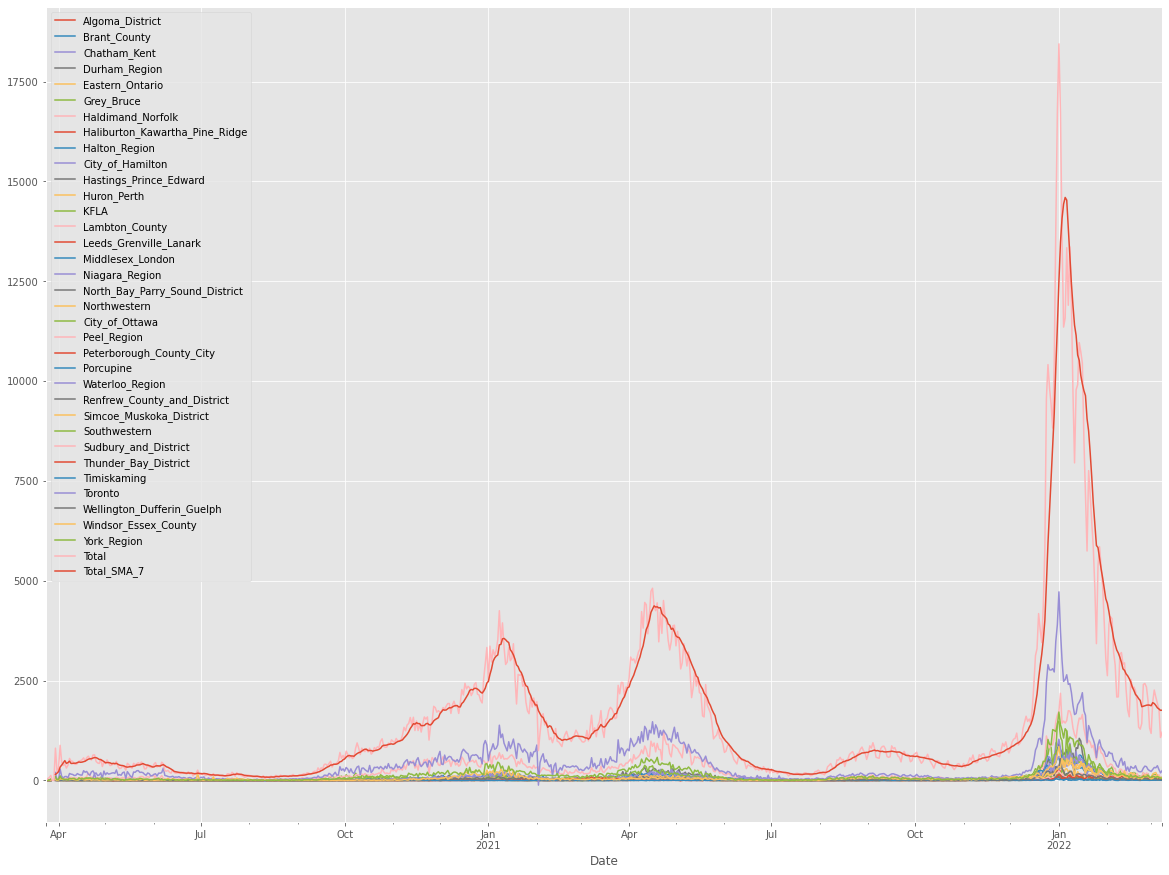

In [10]:
plt.rcParams['figure.figsize']=(20,15)
df.plot()
#plt.show()

In [11]:
# Check correlations

print("Torono-York:", df.Toronto.corr(df.York_Region))
print("Peel-Algoma:", df.Peel_Region.corr(df.Algoma_District))
print("Ottawa-holidays:", df.City_of_Ottawa.corr(dfd.is_wkend_holiday))
print("Toronto-holidays+5:", df.Toronto.corr(dfd.holiday_add5))

Torono-York: 0.9668311149977658
Peel-Algoma: 0.46543800219731635
Ottawa-holidays: 0.13261243077769866
Toronto-holidays+5: 0.18260225616422807


<AxesSubplot:xlabel='Date'>

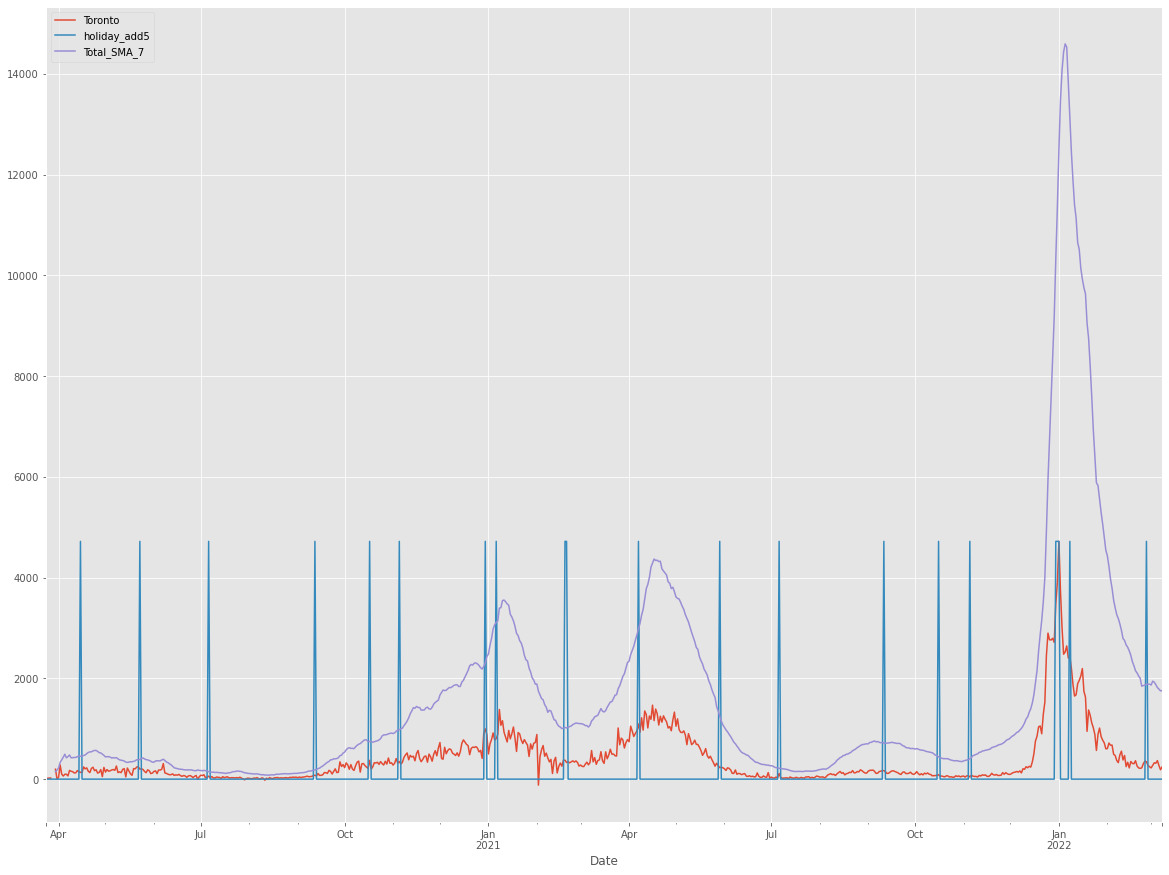

In [12]:
# Visual check on effect of holidays (+5 days)
df1 = df.join(dfd)[['Toronto','holiday_add5', 'Total_SMA_7']]
df1.holiday_add5 *= df1.Toronto.max()   # normalize holidays to Toronto scale
df1.plot()
#plt.show()

## Check on the latest stats:

In [13]:
#df[df.index==pd.to_datetime(datetime.datetime.now().date())]
df.tail()

,Algoma_District,Brant_County,Chatham_Kent,Durham_Region,Eastern_Ontario,Grey_Bruce,Haldimand_Norfolk,Haliburton_Kawartha_Pine_Ridge,Halton_Region,City_of_Hamilton,Hastings_Prince_Edward,Huron_Perth,KFLA,Lambton_County,Leeds_Grenville_Lanark,Middlesex_London,Niagara_Region,North_Bay_Parry_Sound_District,Northwestern,City_of_Ottawa,Peel_Region,Peterborough_County_City,Porcupine,Waterloo_Region,Renfrew_County_and_District,Simcoe_Muskoka_District,Southwestern,Sudbury_and_District,Thunder_Bay_District,Timiskaming,Toronto,Wellington_Dufferin_Guelph,Windsor_Essex_County,York_Region,Total,Total_SMA_7
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-03-04,56.0,11.0,12.0,98.0,34.0,28.0,23.0,22.0,70.0,63.0,17.0,12.0,80.0,20.0,27.0,63.0,55.0,62.0,66.0,145.0,115.0,16.0,19.0,55.0,24.0,198.0,25.0,72.0,51.0,3.0,316.0,42.0,113.0,72.0,2085,1876.571429
2022-03-05,32.0,10.0,19.0,89.0,15.0,30.0,17.0,15.0,63.0,59.0,28.0,18.0,67.0,22.0,20.0,56.0,81.0,22.0,90.0,127.0,110.0,23.0,48.0,57.0,12.0,118.0,27.0,46.0,39.0,13.0,368.0,27.0,66.0,96.0,1930,1818.285714
2022-03-06,44.0,9.0,16.0,82.0,21.0,26.0,18.0,17.0,53.0,65.0,34.0,17.0,67.0,21.0,14.0,73.0,84.0,27.0,45.0,104.0,143.0,17.0,56.0,33.0,16.0,78.0,16.0,76.0,42.0,7.0,270.0,34.0,84.0,78.0,1787,1787.714286
2022-03-07,36.0,7.0,8.0,49.0,11.0,16.0,2.0,18.0,34.0,50.0,14.0,3.0,33.0,12.0,15.0,58.0,40.0,9.0,8.0,69.0,57.0,8.0,11.0,42.0,8.0,29.0,18.0,49.0,31.0,5.0,187.0,24.0,58.0,55.0,1074,1753.285714
2022-03-08,44.0,4.0,14.0,43.0,7.0,13.0,21.0,15.0,38.0,45.0,11.0,6.0,63.0,8.0,12.0,52.0,39.0,10.0,26.0,76.0,76.0,2.0,24.0,42.0,2.0,72.0,20.0,30.0,20.0,5.0,242.0,15.0,56.0,55.0,1208,1757.857143


<AxesSubplot:title={'center':'York Region Covid-19 Cases since Nov 1, 2021'}, xlabel='Date'>

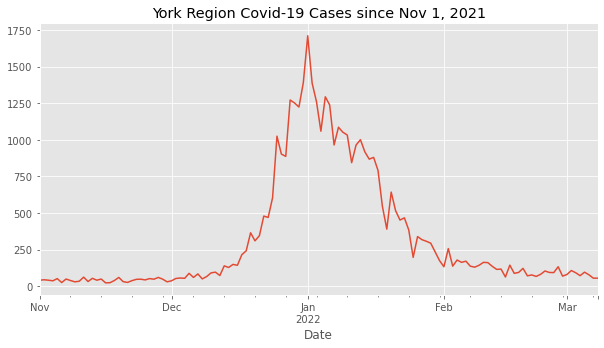

In [14]:
df.York_Region[df.index > pd.to_datetime('2021-10-31')].plot(figsize=(10,5), title='York Region Covid-19 Cases since Nov 1, 2021')
#plt.show()

### Plot York with a couple of moving averages

Plot with SMA and EMA

In [15]:
dfy = pd.DataFrame(df.York_Region[df.index >= pd.to_datetime('2021-01-01')])
dfy.describe()

,York_Region
count,432.000000
mean,188.442130
std,261.483012
min,0.000000
25%,39.000000
50%,93.000000
75%,231.750000
max,1711.000000


<AxesSubplot:xlabel='Date'>

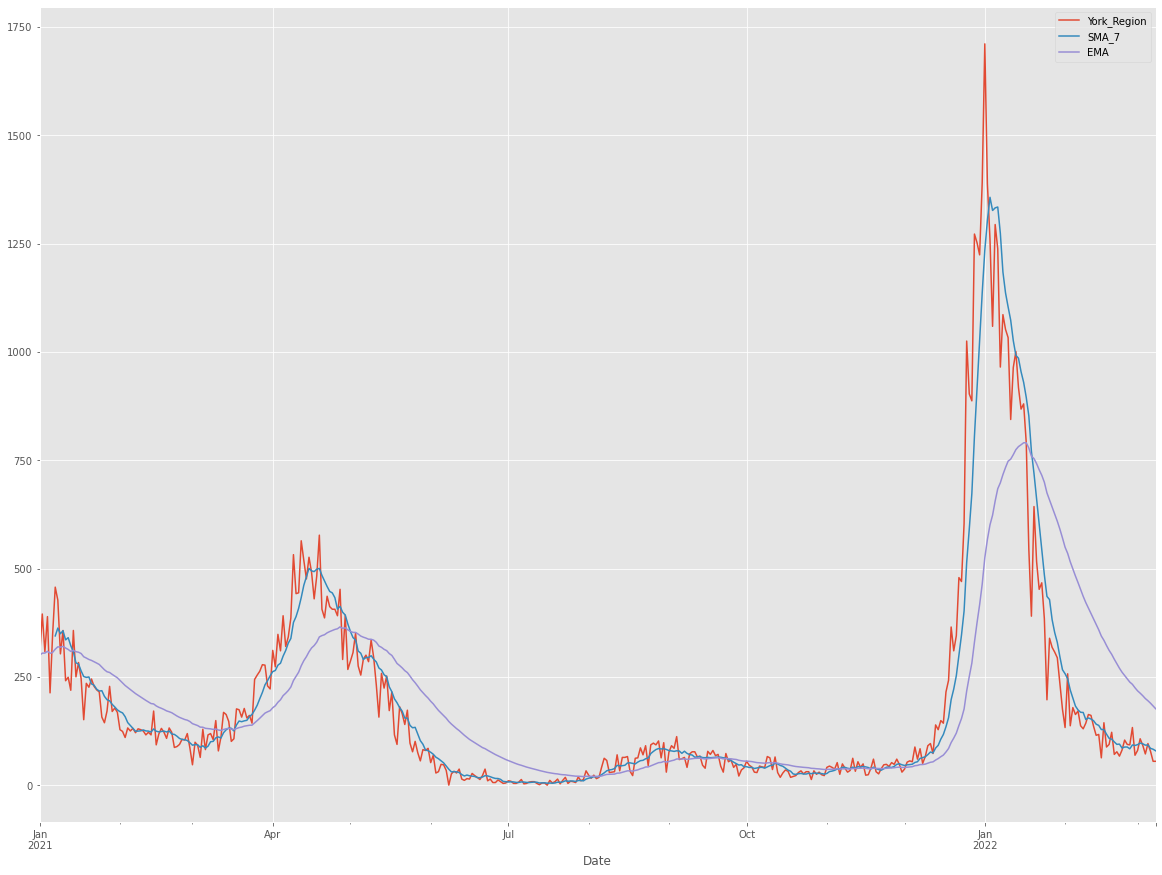

In [16]:
dfy['SMA_7']=dfy.York_Region.rolling(window=7).mean()
dfy['EMA']=dfy.York_Region.ewm(span=40, adjust=False).mean()
dfy.plot()
#plt.show()

## Last 10 Days in Select Regions

In [17]:
# df[df.index > pd.to_datetime(datetime.datetime.now().date() - datetime.timedelta(days=10))][['KFLA','Middlesex_London','York_Region','Toronto','Total']]
df[-10:][['KFLA','Middlesex_London','York_Region','Toronto','Total']]


,KFLA,Middlesex_London,York_Region,Toronto,Total
Date,,,,,
2022-02-27,71.0,51.0,133.0,273.0,2001
2022-02-28,42.0,62.0,69.0,245.0,1315
2022-03-01,81.0,49.0,80.0,223.0,1176
2022-03-02,88.0,54.0,107.0,274.0,1959
2022-03-03,72.0,77.0,92.0,324.0,2262
2022-03-04,80.0,63.0,72.0,316.0,2085
2022-03-05,67.0,56.0,96.0,368.0,1930
2022-03-06,67.0,73.0,78.0,270.0,1787
2022-03-07,33.0,58.0,55.0,187.0,1074


## Covid Hospitalization Stats
URL: https://data.ontario.ca/dataset/8f3a449b-bde5-4631-ada6-8bd94dbc7d15/resource/e760480e-1f95-4634-a923-98161cfb02fa/download/region_hospital_icu_covid_data.csv

In [18]:
hosp_url = "https://data.ontario.ca/dataset/8f3a449b-bde5-4631-ada6-8bd94dbc7d15/resource/e760480e-1f95-4634-a923-98161cfb02fa/download/region_hospital_icu_covid_data.csv"
dfh = pd.read_csv(hosp_url)

# Check last data point
print("Last data point on:", dfh.date.max())

Last data point on: 2022-03-08


In [19]:
# reindex the data frame by date
dfh.date = pd.to_datetime(dfh.date)
dfh.set_index("date", inplace=True)
# dfh.drop(['date'], axis=1, inplace=True)

In [20]:
# Archive the data set (uncomment the following statement)
dfh.to_csv('data/covid19_ontario_hosp_icu.csv')

In [21]:
# data set comprises of distinct regions
dfh.oh_region.unique()

array(['CENTRAL', 'EAST', 'NORTH', 'TORONTO', 'WEST'], dtype=object)

<AxesSubplot:xlabel='date'>

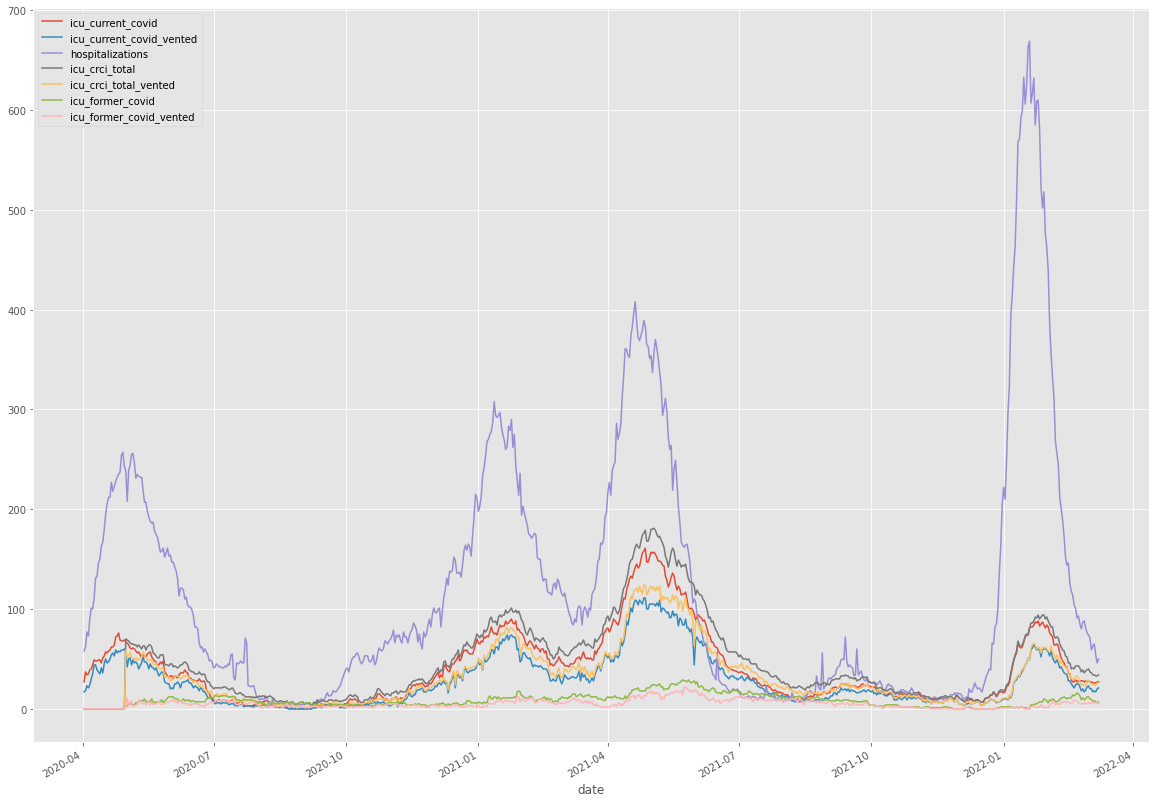

In [22]:
# Plot the Toronto regions
dfh[dfh.oh_region == 'TORONTO'].plot()
#plt.show()

In [23]:
# Aggregate data across the regions
# regions = ['CENTRAL', 'EAST', 'NORTH', 'TORONTO', 'WEST']
# dfh_total = dfh[dfh.oh_region == 'CENTRAL'] + dfh[dfh.oh_region == 'EAST'] + dfh[dfh.oh_region == 'NORTH'] + dfh[dfh.oh_region == 'TORONTO'] + dfh[dfh.oh_region == 'WEST']

# regions = dfh.oh_region.unique()
# dfh_total = dfh[dfh.oh_region == regions[0]]
# for i in range(1, len(regions)):
#     dfh_total += dfh[dfh.oh_region == regions[i]]
# dfh_total.tail()

regions = dfh.oh_region.unique().tolist()
dfh_total = dfh[dfh.oh_region == regions.pop()]
for r in regions:
    dfh_total += dfh[dfh.oh_region == r]
dfh_total.head()


,oh_region,icu_current_covid,icu_current_covid_vented,hospitalizations,icu_crci_total,icu_crci_total_vented,icu_former_covid,icu_former_covid_vented
date,,,,,,,,
2020-04-02,WESTCENTRALEASTNORTHTORONTO,167,112,407,0,0,0,0
2020-04-03,WESTCENTRALEASTNORTHTORONTO,194,140,446,0,0,0,0
2020-04-04,WESTCENTRALEASTNORTHTORONTO,190,149,475,0,0,0,0
2020-04-05,WESTCENTRALEASTNORTHTORONTO,200,154,508,0,0,0,0
2020-04-06,WESTCENTRALEASTNORTHTORONTO,216,160,576,0,0,0,0


Notice that `dfh_total["oh_region"]` now contains a concatenation of the region region names, which is effectively the entire Ontario. Let's rename it to "ONTARIO" to be clear.

The easiest way to rename an entire column is by) `dfh_total["oh_region"] =  new_value` but by default Python will issue a warning: _A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead_

The potential for false positives is addressed in the [docs on indexing](https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy), if you'd like to read further. You can safely disable this new warning with the following assignment.
```python
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
```

Or we could respect the Python suggestion and use `.loc` instead, as in 
```python
dfh_total.loc[:].oh_region = 'ONTARIO'
```

In [24]:
# assign new value to dfh_total.oh_region

dfh_total.loc[:]["oh_region"] = "ONTARIO"
dfh_total.tail()

,oh_region,icu_current_covid,icu_current_covid_vented,hospitalizations,icu_crci_total,icu_crci_total_vented,icu_former_covid,icu_former_covid_vented
date,,,,,,,,
2022-03-04,ONTARIO,219,130,821,262,156,43,26
2022-03-05,ONTARIO,212,124,795,253,147,41,23
2022-03-06,ONTARIO,204,107,761,247,134,43,27
2022-03-07,ONTARIO,204,111,760,249,140,45,29
2022-03-08,ONTARIO,200,116,779,246,141,46,25


In [25]:
# check a data instance
icu1 = dfh[dfh.index == pd.to_datetime('2021-12-01')].icu_current_covid.sum()
icu2 = dfh_total[dfh_total.index == pd.to_datetime('2021-12-01')].icu_current_covid[0]
print("sum of regions({0}) == result column({1}) is {2}".format(icu1, icu2, icu1==icu2))

sum of regions(139) == result column(139) is True


<AxesSubplot:xlabel='date'>

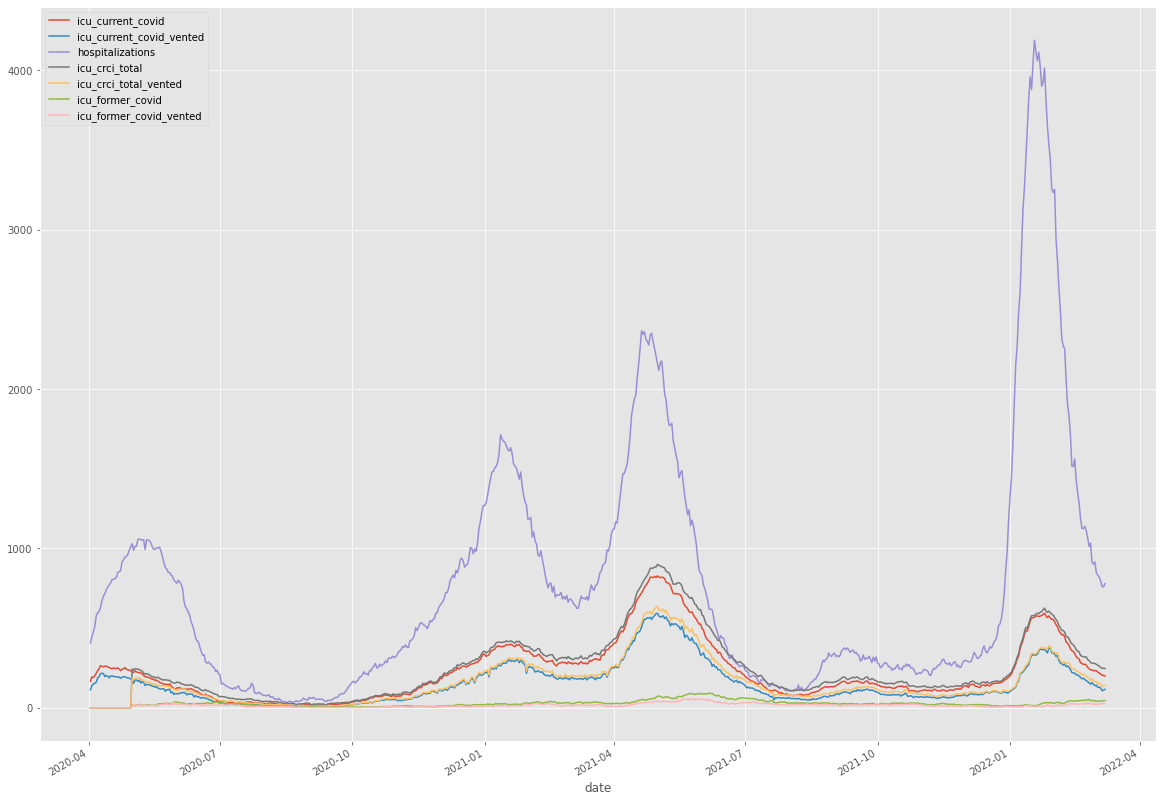

In [26]:
dfh_total.plot()
#plt.show()

## Compare Hospitalization Numbers vs Daily COVID-19 Case

Text(0, 0.5, '% over daily covid cases')

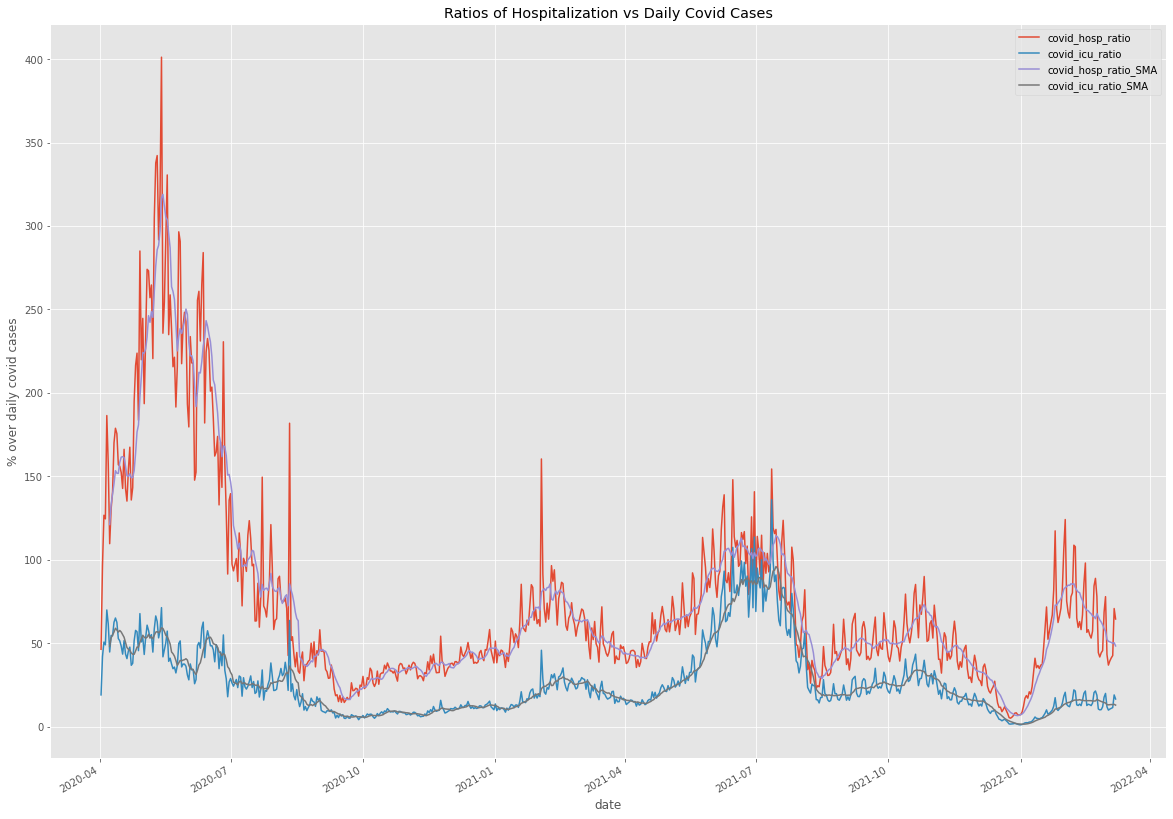

In [27]:
# Generate the ratio columns
covid_hosp_ratio = dfh_total.join(df.Total).apply(lambda row: row['hospitalizations']/row['Total']*100 if row['Total'] != 0 else 0, axis=1).rename('covid_hosp_ratio')
covid_icu_ratio = dfh_total.join(df.Total).apply(lambda row: row['icu_current_covid']/row['Total']*100 if row['Total'] != 0 else 0, axis=1).rename('covid_icu_ratio')

dfh_ratios = dfh_total.join(covid_hosp_ratio).join(covid_icu_ratio)[['covid_hosp_ratio', 'covid_icu_ratio']]

# Generate moving averages
dfh_ratios['covid_hosp_ratio_SMA'] = dfh_ratios.covid_hosp_ratio.rolling(window=7).mean()
dfh_ratios['covid_icu_ratio_SMA'] = dfh_ratios.covid_icu_ratio.rolling(window=7).mean()
# dfh_ratios['covid_hosp_ratio_EMA'] = dfh_ratios.covid_hosp_ratio.ewm(span=40, adjust=False).mean()
# dfh_ratios['covid_icu_ratio_EMA'] = dfh_ratios.covid_icu_ratio.ewm(span=40, adjust=False).mean()

# Plot and label
dfh_ratios.plot()
plt.title('Ratios of Hospitalization vs Daily Covid Cases')
plt.ylabel('% over daily covid cases')
# plt.show()